<a href="https://colab.research.google.com/github/KaterinaVat/ML_DL/blob/main/%5Bseminar%5Dconv_net_optimization_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## 0. Data preparation
transforms.Compose - объединяет несколько преобразований
transforms.ToTensor() преобразует изображения из формата PIL в тензоры PyTorch.
Параметры mean, std передаются как 0,5, 0,5 в вашем случае. Это нормализует изображение в диапазоне [-1,1]. Например, минимальное значение 0 будет преобразовано в (0-0,5)/0,5=-1, максимальное значение 1 будет преобразовано в (1-0,5)/0,5=1.

Это среднее и дисперсия датасета CIFAR10. нужны, что привести нашим данные к среднему 0 и стандартному отклонению 1.  не обязательно использовать их. В пайторче, например, используют значения для ImageNet.

In [3]:



transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=128,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=100,
    shuffle=False,
    num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


## 1. Custom Convolutional model

Попробуем написать свою собственную маленькую конволюционную модель

В методе forward класса Flatten, используется метод view для изменения формы тензора. x.shape[0](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) сохраняет размерность батча, а -1 указывает на то, что все остальные размерности должны быть сжаты в одномерный тензор. Это позволяет преобразовать тензор из формы, например, (batch_size, channels, height, width) в (batch_size, -1), где -1 автоматически рассчитывается как произведение всех оставшихся размерностей.

In [4]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [5]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [6]:
import torchsummary

В этом примере input_size=(3, 32, 32) указывает на размер входных данных для модели, где 3 - это количество каналов (например, RGB для изображений), а 32 - это высота и ширина изображения. Это важно для точных расчетов параметров модели, особенно для моделей обработки изображений

In [7]:
torchsummary.summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
              ReLU-2           [-1, 64, 30, 30]               0
            Conv2d-3           [-1, 10, 28, 28]           5,770
              ReLU-4           [-1, 10, 28, 28]               0
           Flatten-5                 [-1, 7840]               0
            Linear-6                   [-1, 10]          78,410
Total params: 85,972
Trainable params: 85,972
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.06
Params size (MB): 0.33
Estimated Total Size (MB): 1.40
----------------------------------------------------------------


## 2. Write train and test function

In [17]:
def train(model, optim, criterion, dataloader, epoch, device):
    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data) #Выполняется прямой проход (forward pass) через модель, чтобы получить предсказания.
        loss = criterion(output, label) #Вычисляется потеря (loss) между предсказаниями модели и истинными метками с помощью функции потерь.
        loss.backward() #
        optim.step() #Обновляются параметры модели с помощью optim.step(), используя вычисленные градиенты.

        #После каждого шага обновляются переменные train_loss и correct для подсчета суммарной
        #потери и количества правильно классифицированных образцов соответственно.
        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

#train_loss += loss.item():
 Здесь к переменной train_loss прибавляется значение потери (loss), вычисленное в предыдущем шаге. Метод .item() используется для извлечения значения из тензора PyTorch, преобразуя его в число с плавающей точкой. Это делается для каждого батча данных, чтобы в конце эпохи получить среднюю потерю по всем батчам.
# pred = output.argmax(1):
Здесь из выходных данных модели (output) выбирается индекс максимального значения по первой оси (классы), что соответствует предсказанному классу для каждого образца в батче. Это используется для определения, какой класс модель считает наиболее вероятным для каждого образца.
# correct += pred.eq(label).sum().item():
 Здесь к переменной correct прибавляется количество правильно предсказанных образцов. Сначала сравниваются предсказанные классы (pred) с истинными метками (label) с использованием метода .eq(), который возвращает тензор булевых значений, где True указывает на правильное совпадение. Затем метод .sum() суммирует все значения True (то есть правильно предсказанные образцы), и .item() извлекает это значение как число с плавающей точкой. Это делается для каждого батча данных, чтобы в конце эпохи получить общее количество правильно классифицированных образцов.

In [8]:
def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
    total = 0
    correct = 0
    test_loss = 0

    model.eval()
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)

            loss = criterion(output, label)

            test_loss += loss
            pred = output.argmax(1)
            correct += torch.eq(pred, label).sum().item()
            total += data.shape[0]

    acc = 100.*correct/total
    if acc > best_acc:
        # print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(model_name))

    return test_loss / total, acc


## 3. Train Model

In [15]:
from IPython.display import clear_output
import numpy as np

In [10]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

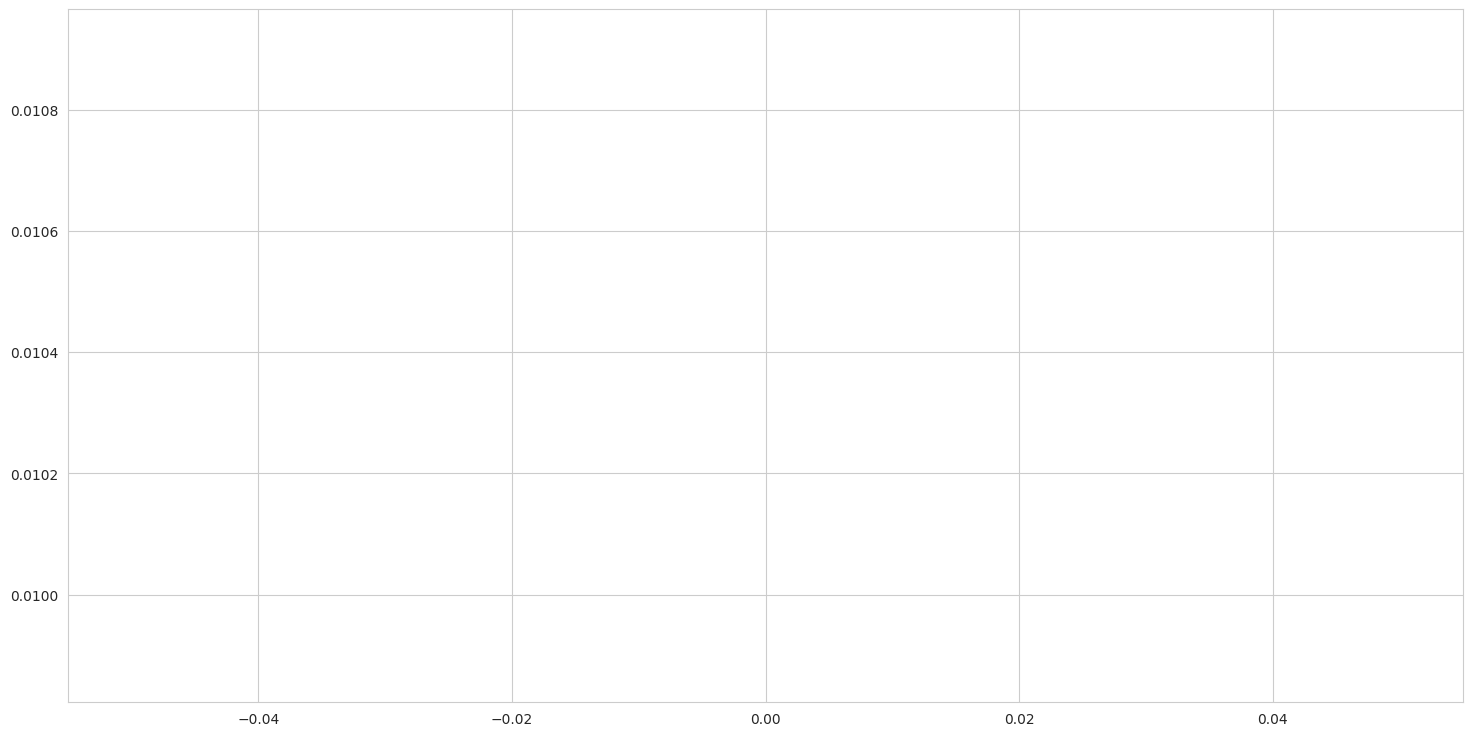

In [16]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc)
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [ ]:
best_acc

58.57

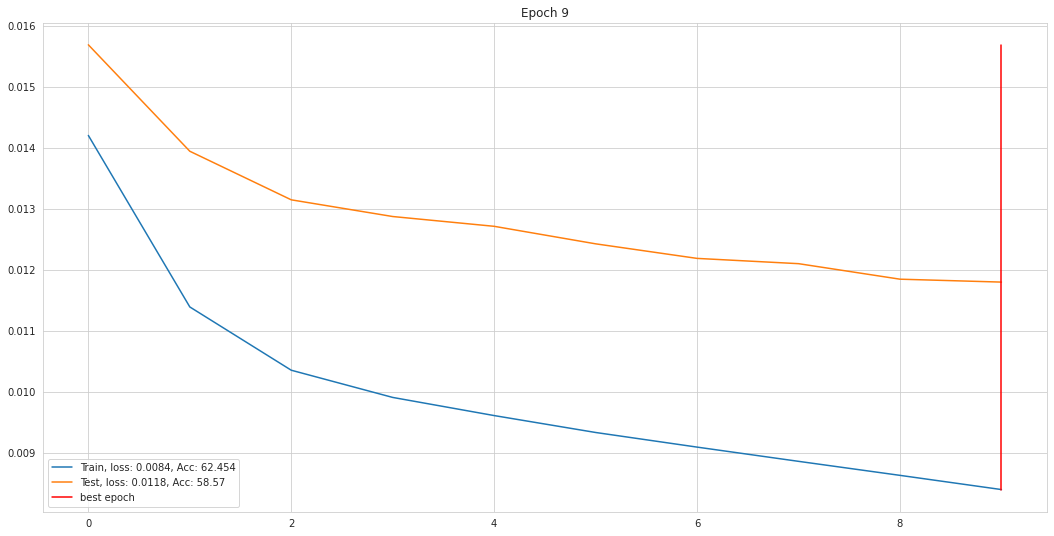

In [ ]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

### BatchNorm

https://arxiv.org/abs/1502.03167

![](https://standardfrancis.files.wordpress.com/2015/04/screenshot-from-2015-04-16-133436.png)

Основные параметры BatchNorm2d включают:

num_features: Количество каналов входного тензора. Для изображений это обычно равно количеству каналов изображения (например, 3 для RGB-изображений).
eps: Маленькое число, добавленное к знаменателю для обеспечения численной стабильности. По умолчанию равно 1e-5.
momentum: Значение, используемое для вычисления скользящего среднего и скользящего отклонения. Может быть установлено в None для использования кумулятивного скользящего среднего (т.е. простого среднего). По умолчанию равно 0.1.
affine: Логическое значение, указывающее, должны ли модуль иметь обучаемые аффинные параметры (масштабирование и смещение). По умолчанию равно True.
track_running_stats: Логическое значение, указывающее, должен ли модуль отслеживать статистику (среднее и отклонение) во время обучения и использовать ее во время тестирования. По умолчанию равно True.

BatchNorm2d помогает уменьшить внутренний сдвиг ковариаций (internal covariate shift), что делает обучение более стабильным и позволяет использовать более высокие скорости обучения. Это также может помочь в улучшении обобщающей способности модели, делая ее менее чувствительной к начальным значениям весов

In [18]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [19]:
torchsummary.summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
       BatchNorm2d-2           [-1, 64, 30, 30]             128
              ReLU-3           [-1, 64, 30, 30]               0
            Conv2d-4           [-1, 10, 28, 28]           5,770
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
           Flatten-7                 [-1, 7840]               0
            Linear-8                   [-1, 10]          78,410
Total params: 86,120
Trainable params: 86,120
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.56
Params size (MB): 0.33
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


Оптимизатор (SGD): optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4) определяет стохастический градиентный спуск (SGD) как оптимизатор для обновления весов модели. Параметры включают:
lr=0.001: начальная скорость обучения.
momentum=0.9: коэффициент момента, который помогает ускорить SGD в направлении предыдущих шагов градиента.
weight_decay=5e-4: коэффициент регуляризации L2, который помогает предотвратить переобучение путем штрафования больших весов 2.

Планировщик скорости обучения (StepLR): optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5) используется для динамического изменения скорости обучения во время обучения. В данном случае, StepLR уменьшает скорость обучения каждые 2 эпохи, умножая текущую скорость обучения на gamma=0.5. Это может помочь модели сходиться быстрее и улучшить ее обобщающую способность

In [20]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

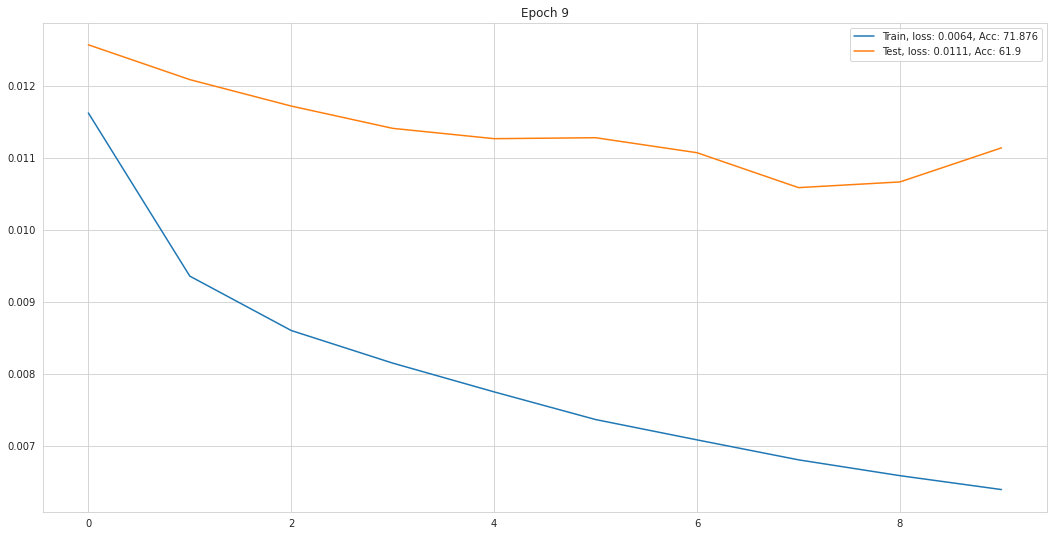

In [ ]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'with_bn')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()

In [ ]:
best_acc

63.88

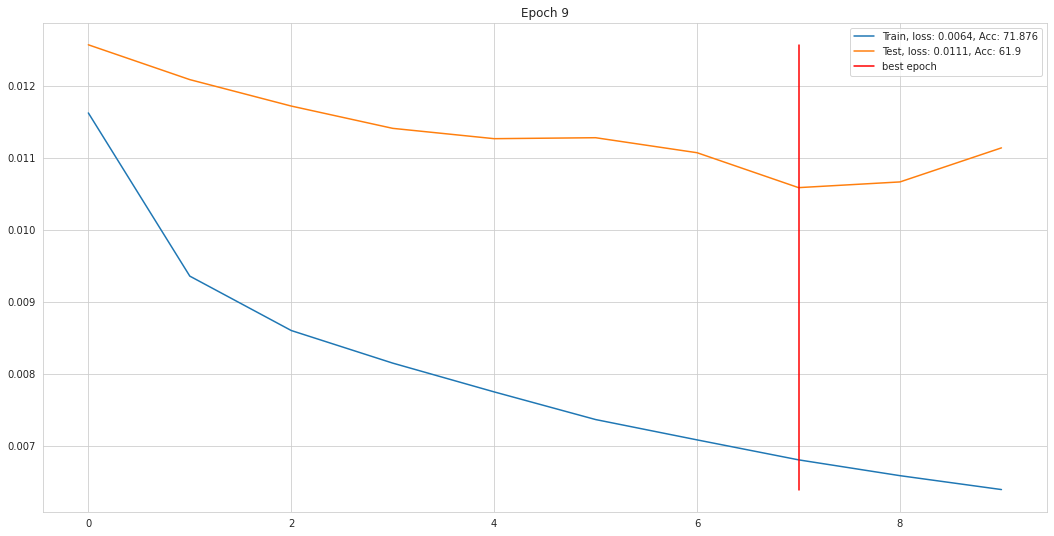

In [ ]:
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
plt.plot(np.ones(10)*best_epoch, np.linspace(np.min(train_losses).item(), np.max(test_losses).item(), 10), color='r', label='best epoch')
plt.title(f'Epoch {i}')
plt.legend(loc='best')

## 4. Add some augmentations

https://pytorch.org/docs/stable/torchvision/transforms.html

Добавим пару аугментаций (`Crop` & `Flip`) и посмотрим, как изменится обучение

transforms.ColorJitter в PyTorch используется для случайного изменения яркости, контраста, насыщенности и оттенка изображения. Это помогает увеличить разнообразие данных для обучения модели, делая ее более устойчивой к изменениям в данных.


RandomRotation(25): Этот преобразование случайным образом вращает изображение на угол в пределах заданного диапазона. В данном случае, изображение может быть повернуто на угол от -25 до 25 градусов. Это помогает увеличить разнообразие данных для обучения модели, делая ее более устойчивой к изменениям в ориентации объектов на изображениях 5.


RandomHorizontalFlip(): Этот преобразование случайным образом переворачивает изображение горизонтально с вероятностью 50% (по умолчанию). Это может быть полезно для увеличения разнообразия данных, особенно когда объекты на изображениях могут быть отображены в разных ориентациях. Переворот изображения горизонтально может помочь модели лучше обобщать и распознавать объекты, даже если они встречаются в разных ориентациях 14.

In [21]:
transform_train = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [22]:
model = nn.Sequential()

# dense "head"
model.add_module('conv1', nn.Conv2d(3, 64, 3))
model.add_module('bn1', nn.BatchNorm2d(64))
model.add_module('conv1_relu', nn.ReLU())
model.add_module('conv2', nn.Conv2d(64, 10, 3))
model.add_module('bn2', nn.BatchNorm2d(10))
model.add_module('conv2_relu', nn.ReLU())

model.add_module('flat', Flatten())
model.add_module('dense', nn.Linear(10*28*28, 10))

In [23]:
def train(model, optim, criterion, dataloader, epoch, device, add_noise=True):
    total = 0
    correct = 0
    train_loss = 0

    model.train()
    for data, label in dataloader:
        if add_noise:
            data = data + torch.empty(*data.size()).normal_(0, 0.0001)
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optim.step()

        train_loss += loss.item()
        pred = output.argmax(1)
        total += output.shape[0]
        correct += pred.eq(label).sum().item()
    return train_loss / total, 100. * correct / total

In [24]:
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 2, gamma=0.5)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

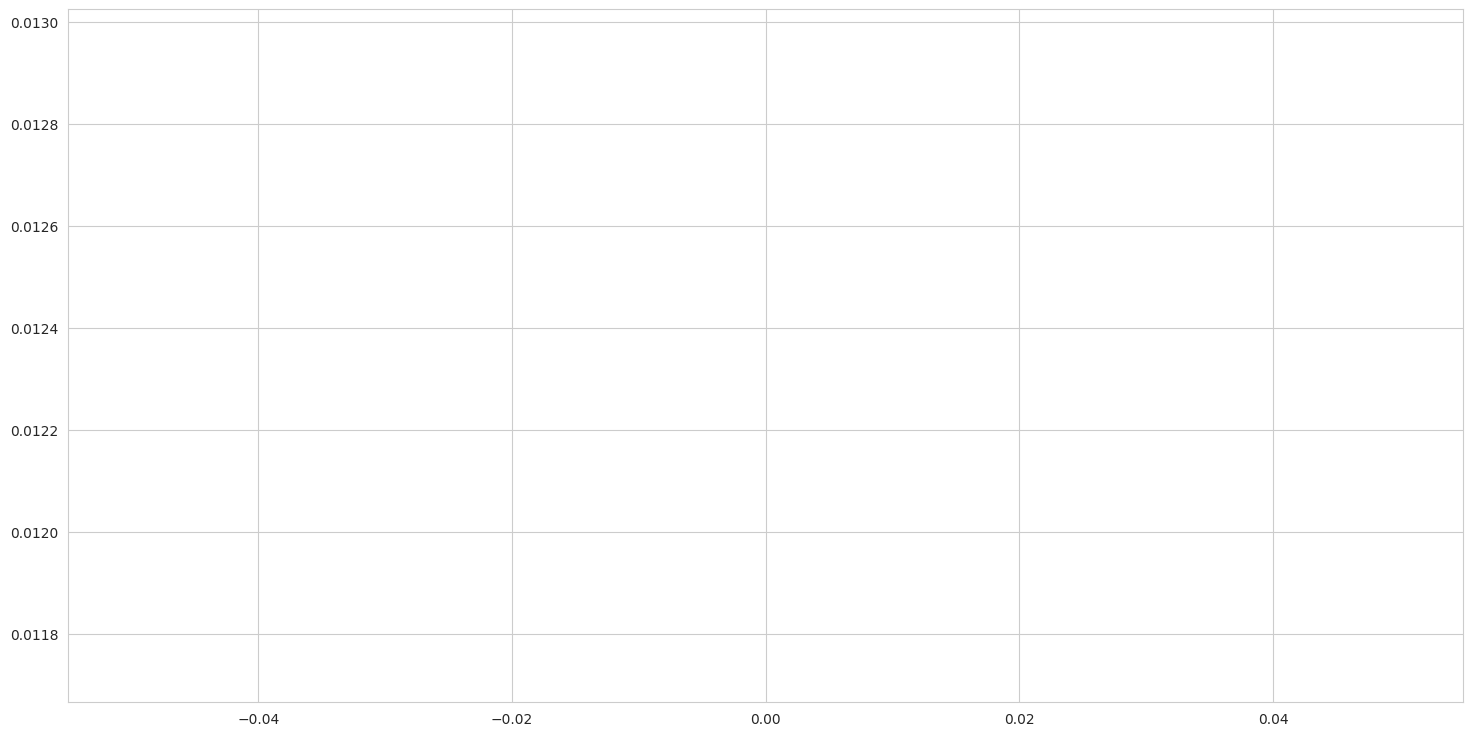

In [25]:
train_losses = []
test_losses = []
best_acc = 0
best_epoch = -1
for i in range(10):
    train_loss, train_acc = train(model, optimizer, criterion, trainloader, i, device)
    train_losses.append(train_loss)
    test_loss, test_acc = test(model, criterion, testloader, i, device, best_acc, 'bn_and_aug')
    scheduler.step(test_loss)
    test_losses.append(test_loss)
    best_acc = max(best_acc, test_acc)
    best_epoch = i if best_acc == test_acc else best_epoch
    clear_output()
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, Acc: {train_acc}')
    plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, Acc: {test_acc}')
    plt.title(f'Epoch {i}')
    plt.legend(loc='best')
    plt.show()